# Hipparcos

### Code to look at Hipparcos time series photometry of Aldebaran using celerite

In [429]:
import numpy as np
import matplotlib.pyplot as plt 

import george
import celerite
from celerite import terms

import emcee
import corner

from scipy.optimize import minimize
from scipy import interpolate

%matplotlib inline
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
colours = mpl.rcParams['axes.color_cycle'] 
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
mpl.rcParams['font.size']=14               #10 
mpl.rcParams['savefig.dpi']= 200             #72 


In [2]:
fname = '../hipp/alpha-Tau-hipp.txt'

In [652]:
def read_hipp(fname):
    with open(fname) as f:
        lines = f.readlines()[27:]

    time, flux, err = 1.*np.zeros(len(lines)), 1.*np.zeros(len(lines)),1.*np.zeros(len(lines))


    for j,line in enumerate(lines):
        if line == '\n':
            break
        l = line.split("|")
        time[j] = l[0]
        flux[j] = l[1]
        err[j] = l[2]

    time = time[:j]
    flux = flux[:j]
    err = err[:j]
    
    return time, flux,err

In [653]:
time, flux, err = read_hipp(fname)
time -= time.min()

<Container object of 3 artists>

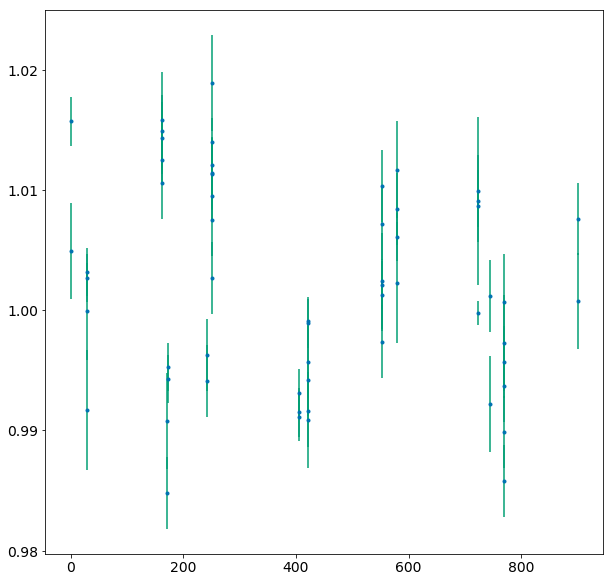

In [657]:
plt.plot(time,flux,'.')
plt.errorbar(time,flux,yerr=err,linestyle="none")
# plt.xlim(150,175)

## Now let's try fitting a model.

In [658]:
tt = np.linspace(time.min(), time.max(), 1000)
y = flux.copy()
# y = np.sin(time/2.)

In [659]:
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15),log_sigma=(-15,15),log_rho=(-15,15))


# A non-periodic component
# Q = 1.0 / np.sqrt(2.0)
# w0 = 3.0
# S0 = np.var(y) / (w0 * Q)
# bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
# kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
#                        bounds=bounds)
# kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

kernel = terms.Matern32Term(log_sigma=np.log10(S0),log_rho=np.log10(10))

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [660]:
gp = celerite.GP(kernel,mean=np.mean(y))
gp.compute(time,yerr=err)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))


Initial log-likelihood: 208.528699027


In [661]:
# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]


In [662]:
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y, gp))


In [663]:
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))


Final log-likelihood: 215.537096743


In [664]:
gp.get_parameter_dict()


OrderedDict([('kernel:terms[0]:log_sigma', -4.9701124809012533),
             ('kernel:terms[0]:log_rho', 0.87967273302552229),
             ('kernel:terms[1]:log_S0', -15.0),
             ('kernel:terms[1]:log_Q', -9.1266876406957635),
             ('kernel:terms[1]:log_omega0', 12.838843386639027)])

In [665]:
mu, cov = gp.predict(y,tt)
sig = np.sqrt(np.diag(cov))

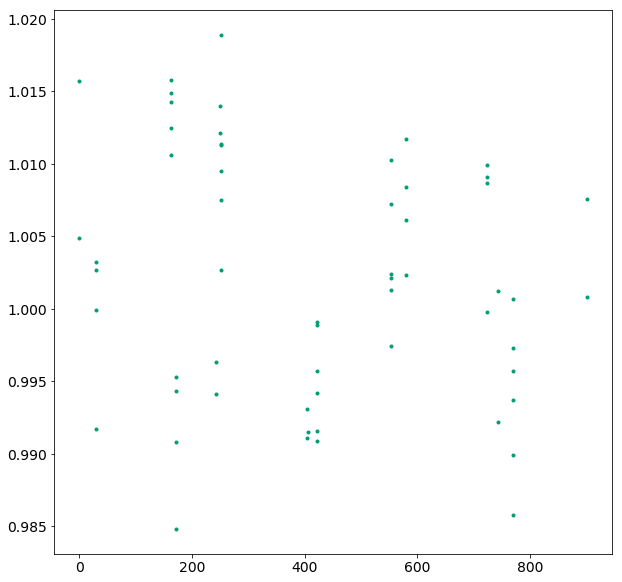

In [666]:
plt.plot(tt,mu)
plt.plot(time,y,'.')


In [667]:
muHz = 2*np.pi/np.exp(gp.kernel.parameter_vector[2])

In [668]:
print muHz

20539841.9236


In [669]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

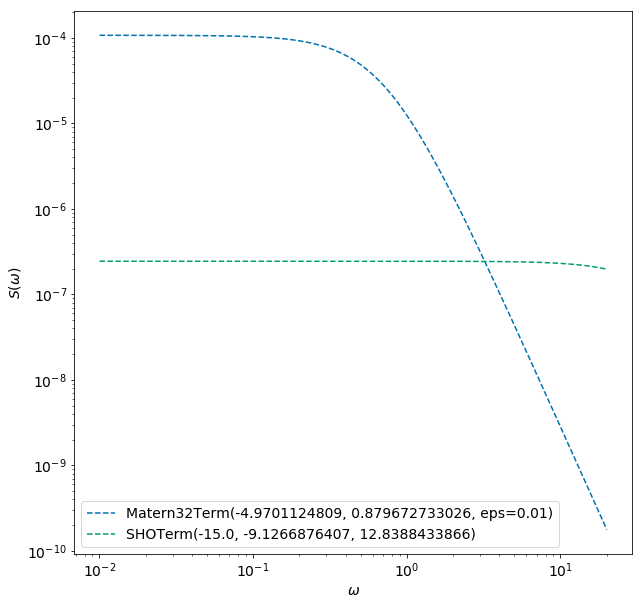

In [670]:
# plt.plot(omega, psd)

for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", label=k)

plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [618]:
ndim = len(gp.get_parameter_dict())
nsteps = 5000
nwalkers = 100

p0 = [np.random.rand(ndim) for i in range(nwalkers)]

def lnprob(walker):
    gp.set_parameter_vector(walker)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y) + lp

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

In [619]:
%%time
pos,prob,state = sampler.run_mcmc(p0, 2000)
sampler.reset()


emcee: Exception while calling your likelihood function:
  params: [  13.87021889  149.05447321   -9.5447214    11.59058748  -14.70369882]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/bjsp/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-393-c81a2a02bdaa>", line 6, in log_probability
    return gp.log_likelihood(y) + lp
  File "/anaconda/lib/python2.7/site-packages/celerite/celerite.py", line 168, in log_likelihood
    self._recompute()
  File "/anaconda/lib/python2.7/site-packages/celerite/celerite.py", line 139, in _recompute
    self.compute(self._t, self._yerr, check_sorted=False)
  File "/anaconda/lib/python2.7/site-packages/celerite/celerite.py", line 131, in compute
    t, self._yerr**2
LinAlgError: failed to factorize or solve matrix


LinAlgError: failed to factorize or solve matrix

In [571]:
%%time
pos,prob,state = sampler.run_mcmc(pos,nsteps)


CPU times: user 2min 14s, sys: 271 ms, total: 2min 14s
Wall time: 2min 15s


('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')


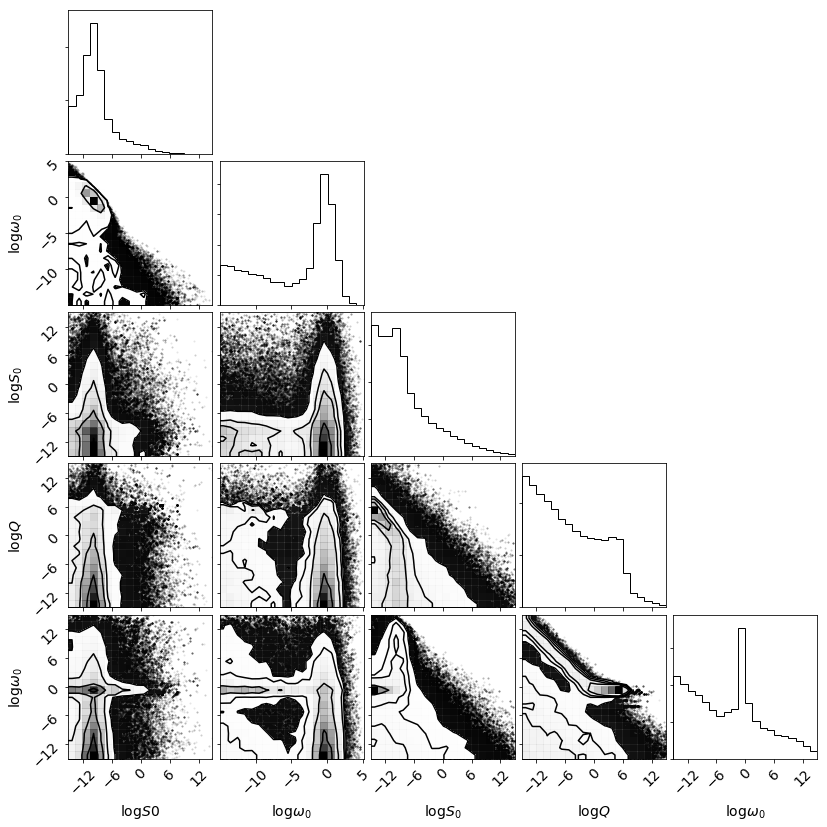

In [572]:
names = gp.get_parameter_names()
print names
labels = [r'$\log S0$', r'$\log \omega_0$', r'$\log S_0$', r'$\log Q$',r'$\log \omega_0$']
corner.corner(sampler.flatchain,labels=labels);

## There is a clear peak in omega 

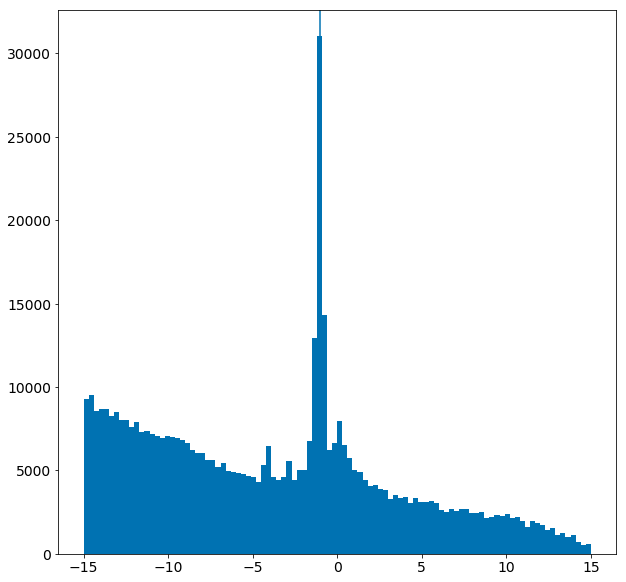

In [573]:
h = plt.hist((sampler.flatchain[:,4]),bins=100)
plt.axvline(-1);

Let's zoom in...

In [583]:
inds = (sampler.flatchain[:,4] < 0)* (sampler.flatchain[:,4]>-2)
print np.exp(np.median(sampler.flatchain[inds,4]))

0.348463196887


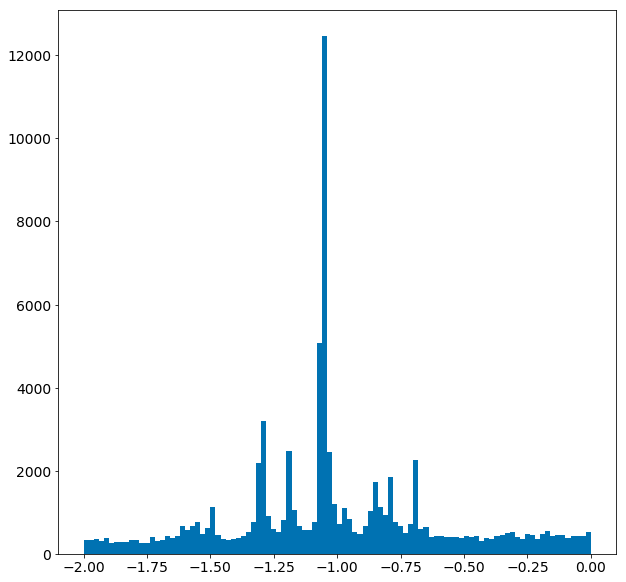

In [584]:
h = plt.hist((sampler.flatchain[inds,4]),bins=100)


What does this PSD look like in this region?

In [585]:
test = sampler.flatchain[inds,:].copy()

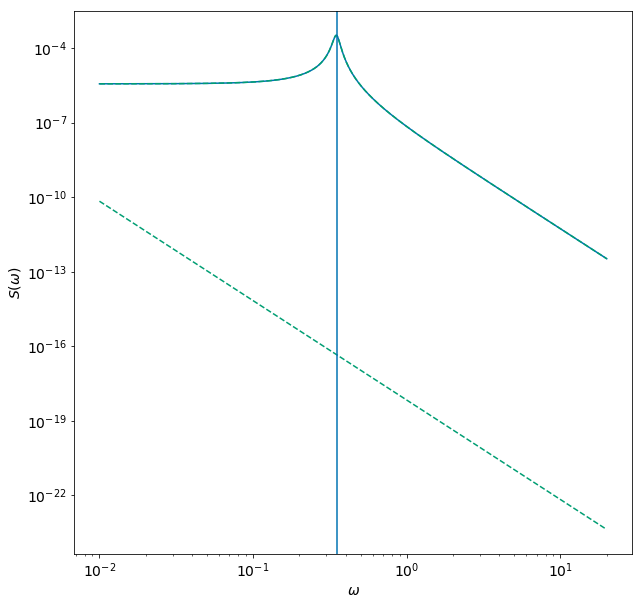

In [586]:
gp.set_parameter_vector(np.median(test,axis=0))
psd = gp.kernel.get_psd(omega)
plt.plot(omega, psd)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=colours[1])
    
plt.axvline(0.34879200544889954)

plt.yscale("log")
plt.xscale("log")
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [587]:
mu, cov = gp.predict(y,tt)
sig = np.sqrt(np.diag(cov))

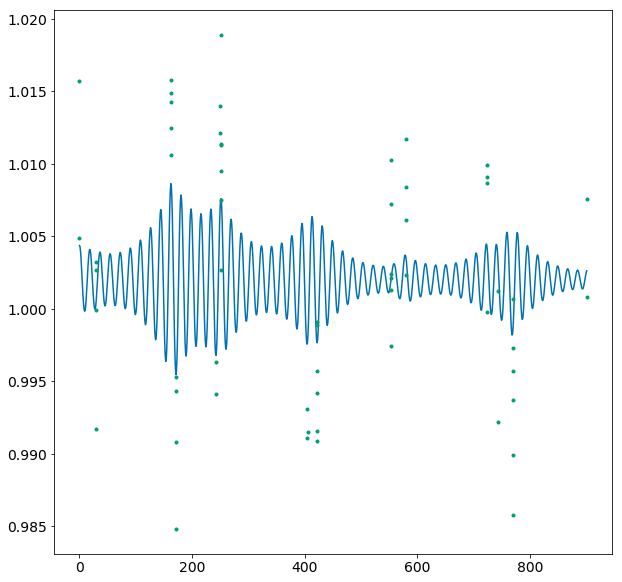

In [588]:
plt.plot(tt,mu)
plt.plot(time,y,'.')
